In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
conn = sqlite3.connect('C://Users//akhil//Desktop//HAP 880//Week 2//testclaims_hu.db')
df = pd.read_sql('select * from highUtilizationPredictionV2wco', conn)

In [3]:
race = pd.get_dummies(df['race'], dummy_na=False)
df=pd.concat([df,race], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
tr, ts = train_test_split(df, test_size=0.2)

In [5]:
cls = list(df.columns)
cls.remove('index')
cls.remove('race')
cls.remove('patient_id')
cls.remove('claimCount')
cls.remove('HighUtilizationY2')

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [7]:
lr = LogisticRegression(solver='lbfgs', C=0.9, max_iter=1000)
lr.fit(tr[cls], tr['HighUtilizationY2'])

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
probs_lr = lr.predict_proba(tr[cls])[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(tr['HighUtilizationY2'], probs_lr)
auc_lr=auc(fpr_lr, tpr_lr)
auc_lr

0.8222127480288721

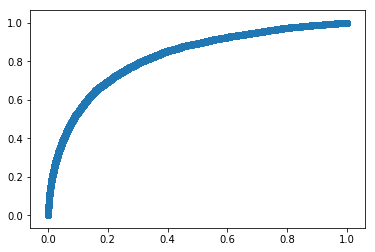

In [9]:
plt.scatter(fpr_lr, tpr_lr)

In [11]:
rf = RandomForestClassifier(n_estimators=400)
rf.fit(tr[cls], tr['HighUtilizationY2'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
probs_rf = rf.predict_proba(ts[cls])[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(ts['HighUtilizationY2'], probs_rf)
auc_rf = auc(fpr_rf, tpr_rf)
auc_rf

0.8077839781778678

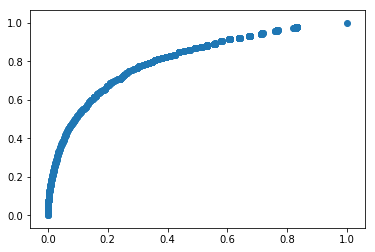

In [13]:
plt.scatter(fpr_rf, tpr_rf)

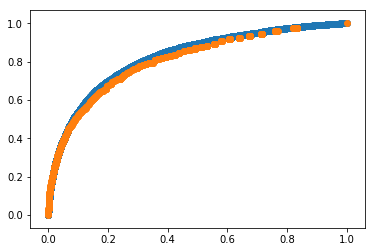

In [14]:
plt.scatter(fpr_lr, tpr_lr)
plt.scatter(fpr_rf, tpr_rf)

# get classification thresholds for recall 0.8

In [15]:
r = 0
while tpr_rf[r] < 0.8:
    r = r+1

In [16]:
 r

473

In [17]:
tpr_rf[r], fpr_rf[r], thresholds_rf[r]

(0.8073270013568521, 0.3582414462164592, 0.05)

In [18]:
l = 0
while tpr_lr[l] < 0.8:
    l = l+1

In [19]:
tpr_lr[l], fpr_lr[l], thresholds_lr[l]

(0.8, 0.3130877557771372, 0.04776322442197152)

In [20]:
ts['HighUtilizationY2'].mean()

0.06520681265206812

In [21]:
probs_rf > 0.05

array([ True, False,  True, ..., False, False, False])

# generate one synthetic patient with all 0s and age 65

In [22]:
age = 65
ELIX = [0 for i in range(29)]
G = [0 for i in range(22)]
drugs = [0 for i in range(12)]
A = 0
AmN = 0
B = 0
H = 0
O = 0
U = 0
W = 0
d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W]

In [23]:
dat = [d]

In [28]:
lr.predict_proba(dat)

array([[0.99381712, 0.00618288]])

In [29]:
rf.predict_proba(dat)

array([[1., 0.]])

# now generate random data

In [35]:
# fixed age
age = 65

# randomly select ELIX codes
ELIX = [np.random.randint(2) for i in range(29)]

# randomly select procedures
G = [np.random.randint(2) for i in range(22)]

# randomly select drug counts
drugs = [np.random.randint(13) for i in range(12)] 

# zero all races
A = 0
AmN = 0
B = 0
H = 0
O = 0
U = 0
W = 0
# and randomly select race
r = np.random.randint(7)
if r == 0:
    A = 1
if r == 1:
    AmN = 1
if r == 2:
    B = 1
if r == 3:
    H = 1
if r == 4:
    O = 1
if r == 5:
    U = 1
if r == 6:
    W = 1    
d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W]
dat = [d]

In [36]:
lr.predict_proba(dat)

array([[0.38471925, 0.61528075]])

In [37]:
rf.predict_proba(dat)[:,1][0]

0.3675

# now simulate 1000 random patients

In [38]:
lr_res = []
rf_res = []
for i in range(1000):
    age = 65
    ELIX = [np.random.randint(2) for i in range(29)]
    G = [np.random.randint(2) for i in range(22)]
    drugs = [np.random.randint(30) for i in range(12)] 
    A = 0
    AmN = 0
    B = 0
    H = 0
    O = 0
    U = 0
    W = 0
    r = np.random.randint(7)
    if r == 0:
        A = 1
    if r == 1:
        AmN = 1
    if r == 2:
        B = 1
    if r == 3:
        H = 1
    if r == 4:
        O = 1
    if r == 5:
        U = 1
    if r == 6:
        W = 1    
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W]
    dat = [d]
    lr_res.append(lr.predict_proba(dat)[:,1][0])
    rf_res.append(rf.predict_proba(dat)[:,1][0])

In [39]:
# calculate mean and std for lr
np.mean(lr_res), np.std(lr_res)

(0.502088237272969, 0.25835451033039747)

In [40]:
#calculate mean and std for rf
np.mean(rf_res), np.std(rf_res)

(0.3406825, 0.07696218515446401)

In [41]:
#get min and max age from training data
maxa = tr['age'].max()
mina = tr['age'].min()

# generate random data for all ages in the data

In [42]:
lr_ages = []
rf_ages = []
for age in range(mina, maxa+1):
    lr_res = []
    rf_res = []
    for i in range(1000):
        ELIX = [np.random.randint(2) for i in range(29)]
        G = [np.random.randint(2) for i in range(22)]
        drugs = [np.random.randint(30) for i in range(12)] 
        A = 0
        AmN = 0
        B = 0
        H = 0
        O = 0
        U = 0
        W = 0
        r = np.random.randint(7)
        if r == 0:
            A = 1
        if r == 1:
            AmN = 1
        if r == 2:
            B = 1
        if r == 3:
            H = 1
        if r == 4:
            O = 1
        if r == 5:
            U = 1
        if r == 6:
            W = 1    
        d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W]
        dat = [d]
        lr_res.append(lr.predict_proba(dat)[:,1][0])
        rf_res.append(rf.predict_proba(dat)[:,1][0])
    lr_ages.append(sum(lr_res)/len(lr_res))
    rf_ages.append(sum(rf_res)/len(rf_res))

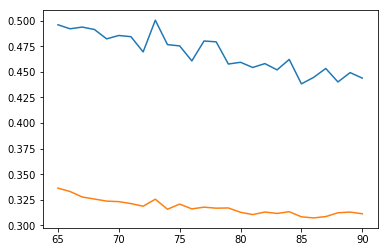

In [45]:
plt.plot(range(mina, maxa+1), lr_ages)
plt.plot(range(mina, maxa+1), rf_ages)

In [46]:
probs_l = lr.predict_proba(tr[cls])[:,1]
probs_r = rf.predict_proba(tr[cls])[:,1]

In [47]:
tr_res = pd.DataFrame()
tr_res['age'] = tr['age']
tr_res['lr'] = probs_l
tr_res['rf'] = probs_r
gr=tr_res.groupby('age')

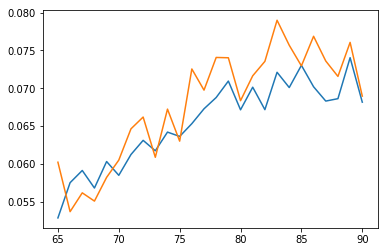

In [49]:
plt.plot(range(mina, maxa+1),list(gr['lr'].mean()))
plt.plot(range(mina, maxa+1),list(gr['rf'].mean()))

In [50]:
probs_l_t = lr.predict_proba(ts[cls])[:,1]
probs_r_t = rf.predict_proba(ts[cls])[:,1]

In [51]:
ts_res = pd.DataFrame()
ts_res['age'] = ts['age']
ts_res['lr'] = probs_l_t
ts_res['rf'] = probs_r_t
grts=ts_res.groupby('age')

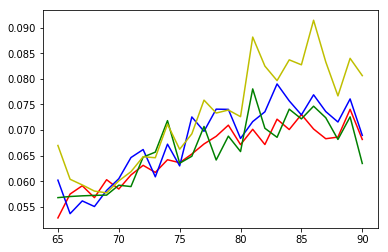

In [52]:
plt.plot(range(mina, maxa+1),list(gr['lr'].mean()), color='r')
plt.plot(range(mina, maxa+1),list(gr['rf'].mean()), color='b')
plt.plot(range(mina, maxa+1),list(grts['lr'].mean()), color='g')
plt.plot(range(mina, maxa+1),list(grts['rf'].mean()), color='y')

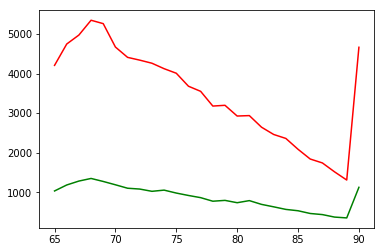

In [54]:
plt.plot(range(mina, maxa+1),list(gr['lr'].count()), color='r')
plt.plot(range(mina, maxa+1),list(grts['lr'].count()), color='g')

# generate data from -5 + 5 range

In [55]:
lr_ages = []
rf_ages = []
for age in range(mina, maxa+1):
    lr_res = []
    rf_res = []
    mn = max(age-5, mina)
    mx = min(age+5, maxa)
    dat = tr[(tr['age'] >= mn) & (tr['age'] <= mx)][cls]
    dat['age'] = age
    probs_l = lr.predict_proba(dat)[:,1]
    probs_r = rf.predict_proba(dat)[:,1]
       
    lr_ages.append(np.mean(probs_l))
    rf_ages.append(np.mean(probs_r))

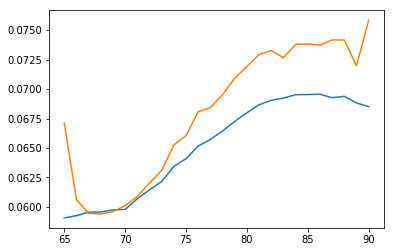

In [56]:
plt.plot(range(mina, maxa+1), lr_ages)
plt.plot(range(mina, maxa+1), rf_ages)

In [57]:
lr_ages = []
rf_ages = []
lr_ages_s = []
rf_ages_s = []
for age in range(mina, maxa+1):
    lr_res = []
    rf_res = []
    mn = max(age-5, mina)
    mx = min(age+5, maxa)
    dat = tr[(tr['age'] >= mn) & (tr['age'] <= mx)][cls]
    dat['age'] = age
    probs_l = lr.predict_proba(dat)[:,1]
    probs_r = rf.predict_proba(dat)[:,1]
       
    lr_ages.append(np.mean(probs_l))
    rf_ages.append(np.mean(probs_r))
    lr_ages_s.append(np.std(probs_l))
    rf_ages_s.append(np.std(probs_r))

In [58]:
np.array(lr_ages) + np.array(lr_ages_s)

array([0.15288717, 0.15291641, 0.15358524, 0.15326905, 0.15364996,
       0.15336019, 0.15481862, 0.15600833, 0.15694053, 0.1594042 ,
       0.16011238, 0.16216223, 0.16273165, 0.16321713, 0.16471616,
       0.16560209, 0.16669071, 0.16668962, 0.16622906, 0.16617294,
       0.16492335, 0.16462625, 0.16318894, 0.16331954, 0.16245649,
       0.16079019])

# plt.plot(range(mina, maxa+1), lr_ages)

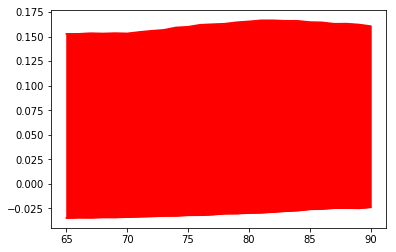

In [59]:
plt.plot(range(mina, maxa+1), np.array(lr_ages) + np.array(lr_ages_s), color='r')
plt.plot(range(mina, maxa+1), np.array(lr_ages) - np.array(lr_ages_s), color='r')
plt.fill_between(range(mina, maxa+1), np.array(lr_ages) + np.array(lr_ages_s), np.array(lr_ages) - np.array(lr_ages_s), color='r')

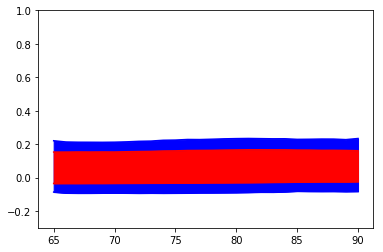

In [60]:
plt.ylim(-0.3,1.0)
plt.plot(range(mina, maxa+1), np.array(rf_ages) + np.array(rf_ages_s), color='b')
plt.plot(range(mina, maxa+1), np.array(rf_ages) - np.array(rf_ages_s), color='b')
plt.fill_between(range(mina, maxa+1), np.array(rf_ages) + np.array(rf_ages_s), np.array(rf_ages) - np.array(rf_ages_s), color='b')
plt.plot(range(mina, maxa+1), np.array(lr_ages) + np.array(lr_ages_s), color='r')
plt.plot(range(mina, maxa+1), np.array(lr_ages) - np.array(lr_ages_s), color='r')
plt.fill_between(range(mina, maxa+1), np.array(lr_ages) + np.array(lr_ages_s), np.array(lr_ages) - np.array(lr_ages_s), color='r')


# look at predicted values per race

In [61]:
tr_res['race'] = tr['race']
ts_res['race'] = ts['race']
gr_r_tr = tr_res.groupby('race')
gr_r_ts = ts_res.groupby('race')

In [62]:
p1 = gr_r_tr.lr.mean()
p2 = gr_r_tr.rf.mean()

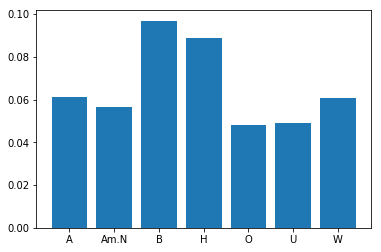

In [64]:
#logistic
plt.bar(range(len(p1.index)), p1.values)
plt.xticks(range(len(p1.index)), p1.index)
plt.show()

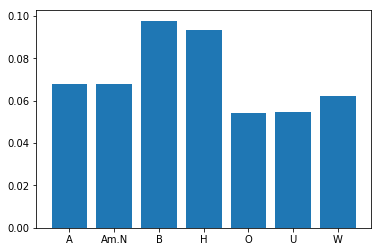

In [65]:
# rf
plt.bar(range(len(p2.index)), p2.values)
plt.xticks(range(len(p2.index)), p2.index)
plt.show()